In [1]:
!pip install --no-deps /kaggle/input/map-utilities/transformers-4.57.0-py3-none-any.whl
!pip install --no-deps /kaggle/input/map-utilities/tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install --no-deps /kaggle/input/map-utilities/bitsandbytes-0.47.0-py3-none-manylinux_2_24_x86_64.whl
!pip install --no-deps /kaggle/input/map-utilities/peft-0.17.1-py3-none-any.whl
!pip install --no-deps /kaggle/input/map-utilities/datasets-4.0.0-py3-none-any.whl
!pip install --no-deps /kaggle/input/map-utilities/huggingface_hub-0.34.4-py3-none-any.whl
!pip install --no-deps /kaggle/input/map-utilities/accelerate-1.10.0-py3-none-any.whl

Processing /kaggle/input/map-utilities/transformers-4.57.0-py3-none-any.whl
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
Processing /kaggle/input/map-utilities/tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Processing /kaggle/input/map-utilities/bitsandbytes-0.47.0-py3-none-manylinux_2_24_x86_64.whl
Processing /kaggle/input/map-utilities/peft-0.17.1-py3-none-any.whl
  Attempting uninstall: peft
    Found existing installation: peft 0.15.2
    Uninstalling peft-0.15.2:
      Successfully uninstalled peft-0.15.2
Processing /kaggle/input/map-utilities/datasets-4.0.0-py3-none-any.whl
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0

In [2]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

ROOT_PATH = os.getcwd()
if "/kaggle" in ROOT_PATH:
    ROOT_PATH = "/kaggle/input"
    sys.path.append(os.path.join(ROOT_PATH, "map-utilities"))

In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from peft import PeftModel
from transformers import BitsAndBytesConfig

from utils import (
    stringify_input,
    get_model_name,
    get_sequence_classifier,
    get_tokenizer,
    get_training_arguments,
    get_trainer,
)

2025-10-05 23:09:58.003354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759705798.179231      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759705798.230550      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
le = joblib.load(os.path.join(ROOT_PATH, "map-utilities", "label_encoder.joblib"))
n_classes = len(le.classes_)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.7.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# BASE_MODEL = "modernbert-large/transformers/default/10"
# BASE_MODEL = "qwen3-1.7b/transformers/default/1"
# BASE_MODEL = "ettin-encoder-1b/transformers/default/8"  # v6 is better
# BASE_MODEL = "qwen-3/transformers/14b/1"
# BASE_MODEL = "gemma-2/transformers/gemma-2-9b-it/2"
BASE_MODEL = "deepseek-r1-0528/transformers/deepseek-r1-0528-qwen3-8b/1"
# BASE_MODEL = "deepseek-math/pytorch/deepseek-math-7b-instruct/1"
# BASE_MODEL = "qwen-3-embedding/transformers/4b/1"
# BASE_MODEL = "qwen-3-embedding/transformers/8b/1"
# BASE_MODEL = "nvidia-acereason-nemotron-1.1-7b/transformers/default/1"
# BASE_MODEL = "llama-3.1/transformers/8b-instruct/2"

MODEL_NAME = get_model_name("/kaggle" in ROOT_PATH, ROOT_PATH, BASE_MODEL)
ADAPTER_PATH = get_model_name("/kaggle" in ROOT_PATH, ROOT_PATH, "deepseek-r1-0528-qwen3-8b-qlora-4bit-5fold/transformers/default/1/fold_2")
USE_LORA = True
USE_QLORA = False
MAX_LEN = 256
NEW_PROMPT = False

TRAIN_PATH = os.path.join(ROOT_PATH, "map-charting-student-math-misunderstandings", "train.csv")
TEST_PATH = os.path.join(ROOT_PATH, "map-charting-student-math-misunderstandings", "test.csv")

In [6]:
qlora_config = {
    "torch_dtype": torch.float16,
    "device_map": "auto"
}

if "ettin-encoder" in MODEL_NAME:
    qlora_config.pop("device_map")

if USE_QLORA:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_storage=torch.float16,
    )
    qlora_config["quantization_config"] = bnb_config

In [7]:
seq_model = get_sequence_classifier(MODEL_NAME, n_classes, qlora_config)
tokenizer = get_tokenizer(MODEL_NAME)

if (
    "gemma" in MODEL_NAME.lower()
    or "qwen" in MODEL_NAME.lower()
    or "deepseek-math" in MODEL_NAME.lower()
    or "llama-3.1" in MODEL_NAME.lower()
):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    seq_model.config.pad_token_id = tokenizer.pad_token_id

if USE_LORA:
    seq_model = PeftModel.from_pretrained(seq_model, ADAPTER_PATH)

`torch_dtype` is deprecated! Use `dtype` instead!
Unrecognized keys in `rope_scaling` for 'rope_type'='yarn': {'attn_factor'}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Qwen3ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/deepseek-r1-0528/transformers/deepseek-r1-0528-qwen3-8b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def tokenize_function(examples):
    return tokenizer(examples["stringified_input"])

In [9]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [10]:
print("Training Shape:", train_df.shape)
print("Testing Shape:", test_df.shape)

Training Shape: (36696, 7)
Testing Shape: (3, 5)


In [11]:
idx = train_df.Category.str.contains("True", case=False)
tmp = train_df.loc[idx].copy()
tmp["c"] = tmp.groupby(["QuestionId", "MC_Answer"]).MC_Answer.transform("count")
tmp = tmp.sort_values("c", ascending=False)
tmp = tmp.drop_duplicates(["QuestionId"])
tmp = tmp[["QuestionId", "MC_Answer"]]
tmp["is_mc_answer_correct"] = True

train_df = train_df.merge(tmp, on=["QuestionId", "MC_Answer"], how="left")
train_df.is_mc_answer_correct = train_df.is_mc_answer_correct.fillna(False)

test_df = test_df.merge(tmp, on=["QuestionId", "MC_Answer"], how="left")
test_df.is_mc_answer_correct = test_df.is_mc_answer_correct.fillna(False)

/tmp/ipykernel_19/1307861462.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.is_mc_answer_correct = train_df.is_mc_answer_correct.fillna(False)
/tmp/ipykernel_19/1307861462.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df.is_mc_answer_correct = test_df.is_mc_answer_correct.fillna(False)


In [12]:
test_df["stringified_input"] = test_df.apply(
    lambda row: stringify_input(row, MODEL_NAME, NEW_PROMPT), axis=1
)
test_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_mc_answer_correct,stringified_input
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",True,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,False,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,True,Question: Which number is the greatest?\nAnswe...


In [13]:
test_df["stringified_input"].values[:5]

array(["Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]\nAnswer: ( (1)/(3) )\nCorrect? Yes\nStudent's Explanation: I think that 1/3 is the answer, as it's the simplest form of 3/9.",
       "Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]\nAnswer: ( (3)/(6) )\nCorrect? No\nStudent's Explanation: i think this answer is because 3 triangles are white and 6 triangle are blue.",
       "Question: Which number is the greatest?\nAnswer: ( 6.2 )\nCorrect? Yes\nStudent's Explanation: because the 2 makes it higher than the others."],
      dtype=object)

In [14]:
test_ds = Dataset.from_pandas(test_df[["stringified_input"]])
test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

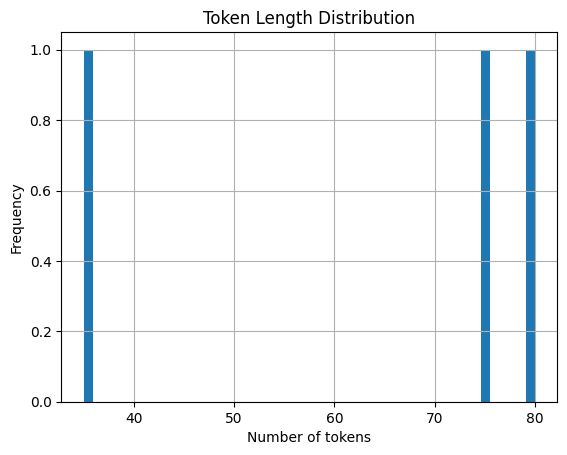

In [15]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in test_ds["stringified_input"]]

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [16]:
L = (np.array(lengths) > MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort(lengths)[::-1]

There are 0 train sample(s) with more than 256 tokens


array([80, 75, 35])

In [17]:
training_args = get_training_arguments(bf16_support="/kaggle" not in ROOT_PATH)
trainer = get_trainer(
    seq_model,
    tokenizer,
    training_args,
    test_ds,
    test_ds,
)

/kaggle/input/map-utilities/utils.py:265: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


In [18]:
predictions = trainer.predict(test_ds)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

In [19]:
top3 = np.argsort(-probs, axis=1)[:, :3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test_df.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Misconception:Wrong_fract...
1,36697,False_Misconception:WNB False_Misconception:In...
2,36698,True_Neither:NA True_Correct:NA True_Misconcep...
